# PS reconstruction slice emittance example

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan, run_t_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan, train_3d_scan_parallel_gpus

from bmadx.beam_generator import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

## Create synthetic ground truth beam

In [2]:
p0c = 10.0e6
gt_beam = create_beam(
    base_yaml = os.path.join('base.yaml'),
    transforms_yaml = os.path.join('transforms.yaml'),
    p0c = p0c,
    save_as = os.path.join('gt_beam.pt'),
    n_particle=10000
)

ground truth distribution saved at gt_beam.pt


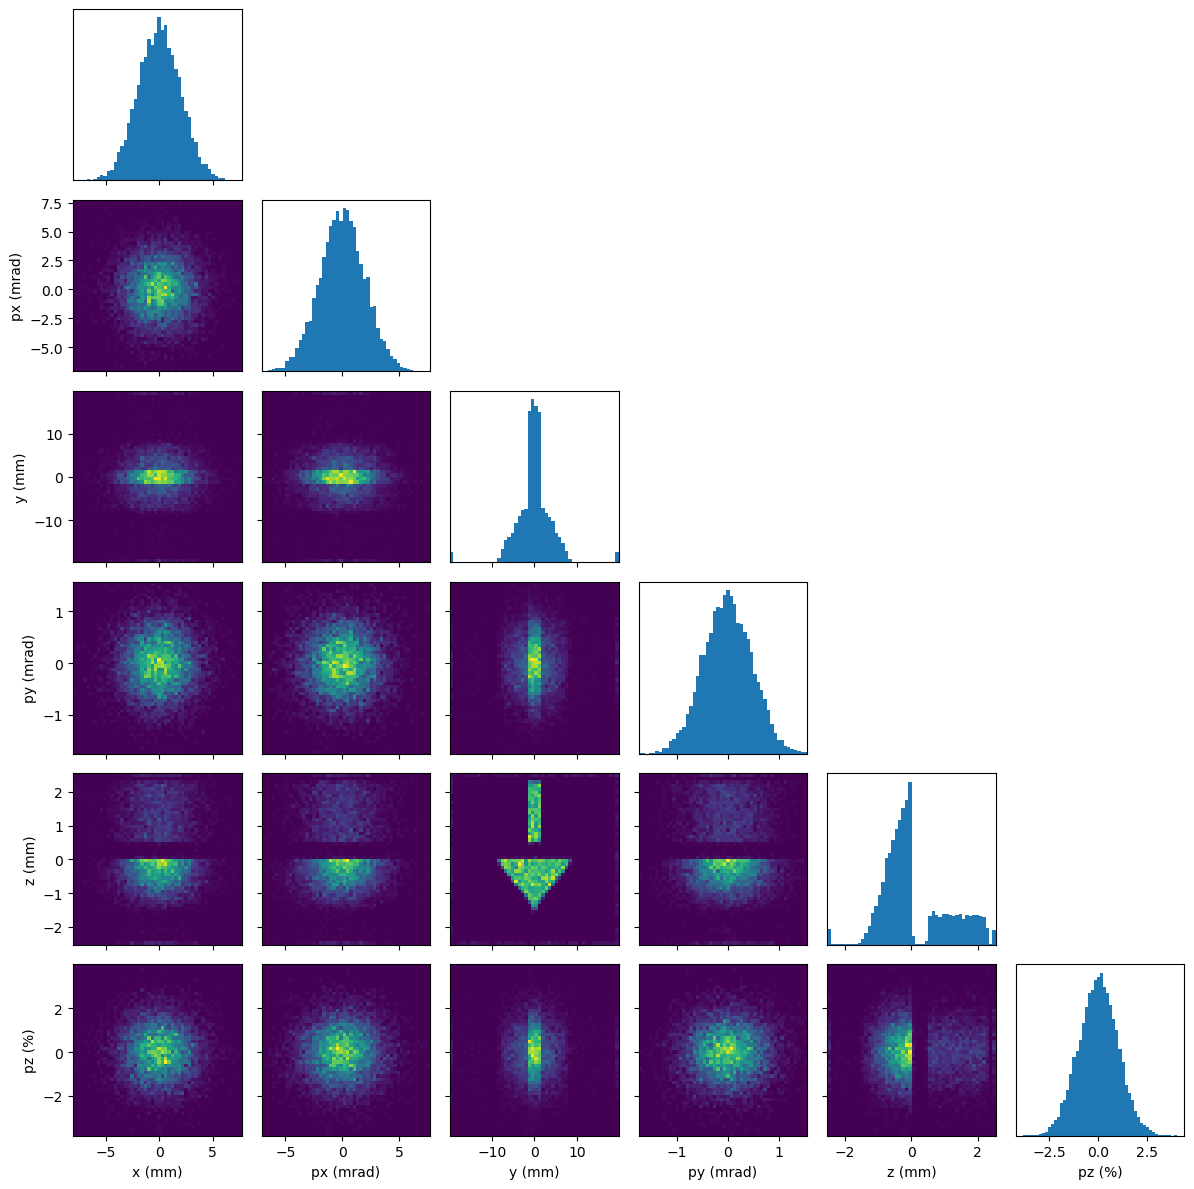

In [3]:
#plot gt beam
lims = np.array([[-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-10e-2, 10e-2]])

# swap x-z distributions
data = gt_beam.data.clone()
data = torch.index_select(data, -1, torch.tensor([4,1,2,3,0,5]))
gt_beam.data = data

fig, ax = plot_projections(
    gt_beam.numpy_particles(),
    same_lims=False,
    background = 1
)



plt.show()

## Define diagnostics lattice parameters

In [4]:
# triplet params obtained from triplet-opt.ipynb
k1 = 7.570125
k2 = -15.704693
k3 = 1.0

In [10]:
# diagnostic beamline:
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
#lattice.elements[0].K1.data = torch.tensor(k1)
#lattice.elements[2].K1.data = torch.tensor(k2)
#lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 7
ks = torch.linspace(-10, 10, n_ks) # quad ks
vs = torch.tensor([0, 5e6]) # TDC off/on
gs = torch.tensor([2.22e-16, 20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
print(train_params.shape)
print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins = torch.linspace(-60, 60, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

torch.Size([3, 7, 2, 2])
torch.Size([3, 7, 2, 2, 1])


## Complete 3D scan training data

In [11]:
# generate and save train and test datasets
train_dset_3d_scan = run_3d_scan(
    gt_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = scan_ids,
    save_as = '3d_scan_train.dset'
)

print(train_dset_3d_scan.params.shape)
print(train_dset_3d_scan.images.shape)

dataset saved as '3d_scan_train.dset'
torch.Size([28, 3, 1])
torch.Size([28, 1, 200, 200])


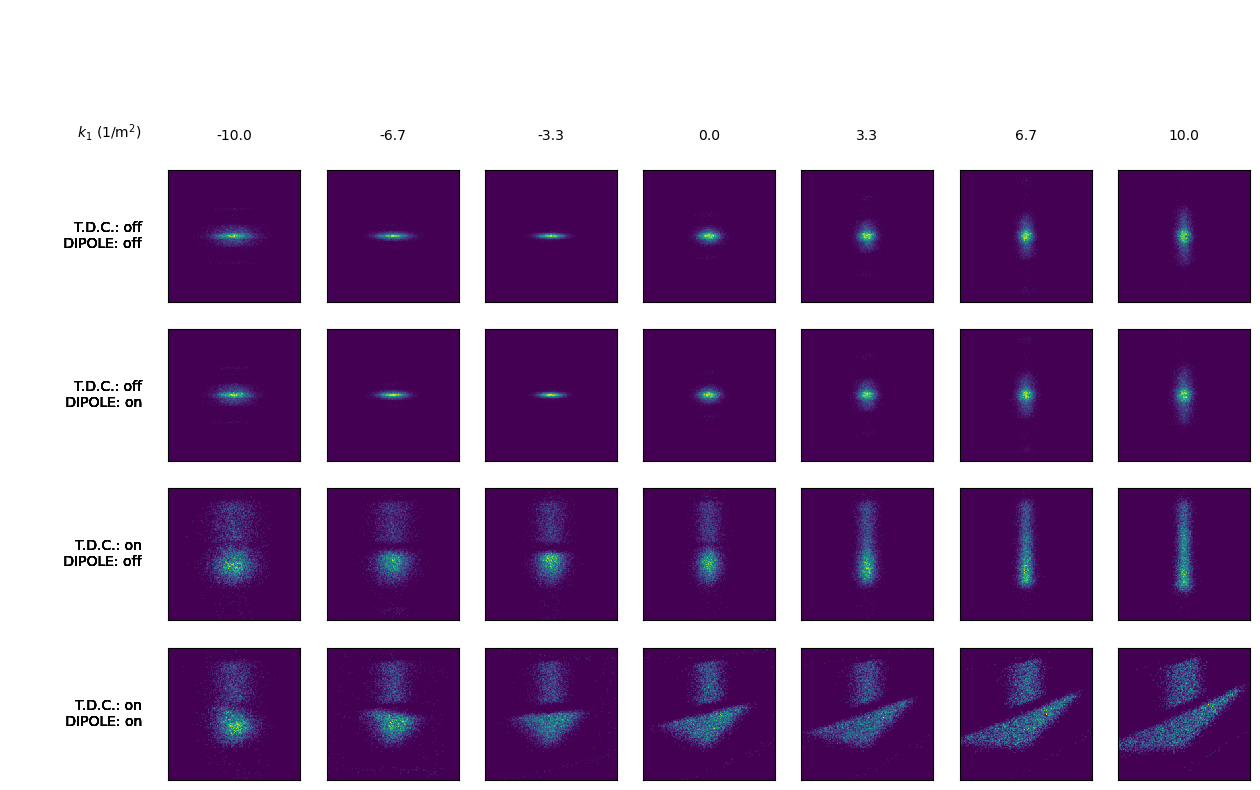

In [12]:
fig, ax = plot_3d_scan_data(train_dset_3d_scan)
plt.show()

### 10,000 particles, multi-GPU

In [8]:
%%time

# training with 4 gpus
pred_beam_3d_scan_10_000 = train_3d_scan(
    train_dset_3d_scan, 
    lattice, 
    p0c, 
    screen,
    ids = scan_ids,
    n_epochs = 1_000, 
    n_particles = 10_000, 
    device = 'cuda:0'
    )

Using device: cuda:0


C:\Users\Ryan Roussel\mambaforge\envs\phase_space_reconstruction\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(2366072.2500, device='cuda:0', grad_fn=<MulBackward0>)


KeyboardInterrupt: 

In [9]:
# reconstructed beam projections:
fig, ax = plot_projections(
    pred_beam_3d_scan_10_000.numpy_particles(),
    same_lims=False,
    background = 1
)

type: name 'pred_beam_3d_scan_10_000' is not defined

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.save(
    pred_beam_3d_scan_10_000,
    os.path.join(save_dir, '3D_scan_10_000.pt'))